In [16]:
from time import time
import datetime

import torch
import torchvision
from torchvision import transforms
# from torchinfo import summary

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset

In [17]:
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=100, dropout=0.5):
        super().__init__()
        k = 3
        p = k // 2
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=k, padding=p),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=k, padding=p),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=k, padding=p),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=k, padding=p),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=k, padding=p),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=k, padding=p),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=k, padding=p),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=k, padding=p),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=k, padding=p),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=k, padding=p),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=k, padding=p),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=k, padding=p),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        # x = self.softmax(x)
        
        return x
        
# print(VGG16(num_classes=100))
# summary(VGG16(num_classes=100), input_size=(50, 3, 32, 32))
        

In [18]:
class Model:
    def __init__(
        self,
        network=None,
        loss_func=None,
        optimizer=None,
        scheduler_t=None,
    ):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = network.to(self.device)
        self.loss_func = loss_func
        self.optimizer = optimizer
        if scheduler_t is not None:
            assert isinstance(scheduler_t, tuple), "scheduler_t must be a tuple"
            assert len(scheduler_t) == 2, "scheduler_t must have two elements"
            assert isinstance(scheduler_t[0], torch.optim.lr_scheduler.LRScheduler), "scheduler_t[0] must be a torch.optim.lr_scheduler type"
            assert isinstance(scheduler_t[1], str), "scheduler_t[1] must be a string"
            assert scheduler_t[1] in [
                "epoch",
                "batch",
            ], "scheduler_t[1] must be either 'epoch' or 'batch'"
        self.scheduler_t = scheduler_t

    def train_1epoch(self, dl):
        self.network.train()
        total_loss = 0.0
        total_corr = 0.0

        for inputs, labels in dl:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            output = self.network(inputs)
            loss = self.loss_func(output, labels)

            _, pred = torch.max(output.detach(), dim=1)
            corr = torch.sum(pred == labels.data).item()

            total_loss += loss.item() * len(inputs)
            total_corr += corr

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.scheduler_t is not None and self.scheduler_t[1] == "batch":
                self.scheduler_t[0].step()
        if self.scheduler_t is not None and self.scheduler_t[1] == "epoch":
            self.scheduler_t[0].step()

        train_loss = total_loss / len(dl.dataset)
        train_acc = total_corr / len(dl.dataset)

        return train_loss, train_acc

    def val_1epoch(self, dl):
        if dl is None:
            return None, None

        self.network.eval()
        total_loss = 0.0
        total_corr = 0.0

        with torch.no_grad():
            for inputs, labels in dl:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                output = self.network(inputs)
                loss = self.loss_func(output, labels)

                _, pred = torch.max(output.detach(), dim=1)
                corr = torch.sum(pred == labels.data).item()
                
                total_loss += loss.item() * len(inputs)
                total_corr += corr
                

        val_loss = total_loss / len(dl.dataset)
        val_acc = total_corr / len(dl.dataset)

        return val_loss, val_acc

    def val_tp(self, dl):
        if dl is None:
            return None, None, None

        self.network.eval()
        total_loss = 0.0
        total_corr = 0.0

        true_list = None
        pred_list = None

        with torch.no_grad():
            for inputs, labels in dl:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                output = self.network(inputs)
                loss = self.loss_func(output, labels)

                _, pred = torch.max(output.detach(), dim=1)
                corr = torch.sum(pred == labels.data).item()

                total_loss += loss.item() * len(inputs)
                total_corr += corr

                if true_list is None:
                    true_list = labels
                else:
                    true_list = torch.cat([true_list, labels])

                if pred_list is None:
                    pred_list = pred
                else:
                    pred_list = torch.cat([pred_list, pred])

        val_loss = total_loss / len(dl.dataset)
        val_acc = total_corr / len(dl.dataset)
        true_list = true_list.cpu()
        pred_list = pred_list.cpu()

        # val_f1 = precision_score(y_true=true_list, y_pred=pred_list, average="macro", zero_division=0.0)
        return true_list, pred_list

    def psuedo(self, dl, th=0.9):
        self.network.eval()
        total_idx = None
        total_plabel = None

        with torch.no_grad():
            for inputs, indices in dl:
                inputs = inputs.to(self.device)
                output = self.network(inputs)
                output = output.detach()
                output = torch.nn.Softmax(dim=1)(output)
                
                prob, pred = torch.max(output, dim=1)
                
                # probがth以上のインデックスを取得
                tmp_indices = (prob >= th).nonzero(as_tuple=True)[0]
                indices = indices[tmp_indices.cpu()]
                plabels = pred[tmp_indices]

                if total_idx is None:
                    total_idx = indices
                else:
                    # total_idx.extend(indices)
                    total_idx = torch.cat((total_idx, indices), dim=0)

                if total_plabel is None:
                    total_plabel = plabels
                else:
                    # total_plabel.extend(labels)
                    total_plabel = torch.cat((total_plabel, plabels), dim=0)

        return total_idx.tolist(), total_plabel.tolist()


    def printlog(self, log_dict, e, epochs, itv=10, anyval=False):
        if e == 1:
            self.start_time = time()
        else:
            stop_time = time()
            req_time = (stop_time - self.start_time) / (e - 1) * epochs
            left = self.start_time + req_time - stop_time
            eta = (datetime.datetime.now() + datetime.timedelta(seconds=left) + datetime.timedelta(hours=9)).strftime("%Y-%m-%d %H:%M")
            t_hour, t_min = divmod(left // 60, 60)
            left = f"{int(t_hour):02d}:{int(t_min):02d}"

        disp_str = ""
        for key, value in log_dict.items():
            try:
                if key == "epoch":
                    disp_str += f"Epoch: {value:>4}/{value - (e-1) - 1 + epochs:>4}"
                else:
                    if anyval:
                        disp_str += f"    {key}: {value}"
                    else:
                        disp_str += f"    {key}: {value:<9.7f}"
            except Exception:
                pass
        if (e - 1) != 0:
            disp_str += f"    eta: {eta} (left: {left})"

        if (e - 1) % itv >= itv - 1 or e == epochs:
            print(disp_str)
        else:
            print(disp_str, end="\r")


In [19]:
to_tsr = transforms.ToTensor()
cf_norm = transforms.Normalize(
    mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
    std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404],
    inplace=True,
)
transforms = transforms.Compose([to_tsr, cf_norm])
# dataset = torchvision.datasets.CIFAR100(root="./", train=True, transform=transforms, download=True)
train_ds = torchvision.datasets.CIFAR10(root="/home/haselab/Documents/tat/Research/assets/datasets", train=True, transform=transforms, download=False)
val_ds = torchvision.datasets.CIFAR10(root="/home/haselab/Documents/tat/Research/assets/datasets", train=False, transform=transforms, download=False)

class AddIdxWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, target, idx
    
class LabeledWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labeled = []

    def append_data(self, indices, labels=None):
        if labels is None:
            self.labeled.extend([(idx, None) for idx in indices])
        else:
            self.labeled.extend([(idx, plabel) for idx, plabel in zip(indices, labels)])
            
    def __len__(self):
        return len(self.labeled)

    def __getitem__(self, idx):
        d_idx, ptarget = self.labeled[idx]
        data, target, _ = self.dataset[d_idx]
        if ptarget is not None:
            target = ptarget
        return data, target
    
class UnlabeledWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.unlabeled = [idx for idx in range(len(self.dataset))]

    def del_data(self, indices, labels=None):
        self.unlabeled = [idx for idx in self.unlabeled if idx not in indices]
        
    def __len__(self):
        return len(self.unlabeled)

    def __getitem__(self, idx):
        d_idx = self.unlabeled[idx]
        data, target, _ = self.dataset[d_idx]
        return data, d_idx
    


In [20]:
lr = 0.0001
batch_size = 250
epochs = 50

# from torchvision.models import vgg16 as net
# network = net(num_classes=10, dropout=0)
network = VGG16(num_classes=10, dropout=0.4)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=lr)

model = Model(network, loss_func, optimizer)

num_train = 1000

train_ds = AddIdxWrapper(train_ds)
labeled_ds = LabeledWrapper(train_ds)
unlabeled_ds = UnlabeledWrapper(train_ds)

labeled_ds.append_data(indices=list(range(0, num_train)))
unlabeled_ds.del_data(indices=list(range(0, num_train)))

train_loader = DataLoader(labeled_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

log_epoch = []
log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []
log_num_labels = []

for e in range(epochs):
    train_loss, train_acc = model.train_1epoch(train_loader)
    val_loss, val_acc = model.val_1epoch(val_loader)

    met_dict = {"epoch": e + 1, "train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
    log_epoch.append(e)
    log_train_loss.append(train_loss)
    log_train_acc.append(train_acc)
    log_val_loss.append(val_loss)
    log_val_acc.append(val_acc)
    log_num_labels.append(len(train_loader.dataset))

    model.printlog(met_dict, e + 1, epochs, itv=1)

    if (e+1) >= 10 and (e+1) % 5 == 0:
        total_indices, total_plabel = model.psuedo(test_loader, th=0.95)
        labeled_ds.append_data(total_indices, total_plabel)
        unlabeled_ds.del_data(total_indices, total_plabel)
        print(len(train_loader.dataset))
        

        # total_indices = total_indices[:10]
        # total_plabel = total_plabel[:10]
        # print(total_indices)
        # print(total_plabel)

        # print(len(total_plabel))
        # print(len(train_loader.dataset))
        # print(len(test_loader.dataset))



1000
10000
49000
Epoch:    1/  50    train_loss: 3.3235256    train_acc: 0.1100000    val_loss: 2.3063028    val_acc: 0.1000000
Epoch:    2/  50    train_loss: 2.6246018    train_acc: 0.1180000    val_loss: 2.3076154    val_acc: 0.1000000    eta: 2024-01-22 23:24 (left: 00:02)
Epoch:    3/  50    train_loss: 2.3620423    train_acc: 0.1340000    val_loss: 2.3163218    val_acc: 0.1000000    eta: 2024-01-22 23:24 (left: 00:02)
Epoch:    4/  50    train_loss: 2.3060484    train_acc: 0.1120000    val_loss: 2.3145511    val_acc: 0.1000000    eta: 2024-01-22 23:24 (left: 00:01)
Epoch:    5/  50    train_loss: 2.2800865    train_acc: 0.1230000    val_loss: 2.3295348    val_acc: 0.1004000    eta: 2024-01-22 23:24 (left: 00:01)
Epoch:    6/  50    train_loss: 2.2615635    train_acc: 0.1420000    val_loss: 2.3285866    val_acc: 0.1022000    eta: 2024-01-22 23:24 (left: 00:01)
Epoch:    7/  50    train_loss: 2.2682430    train_acc: 0.1220000    val_loss: 2.3198009    val_acc: 0.1047000    eta: 202

Text(248.7222222222224, 0.5, 'true_label')

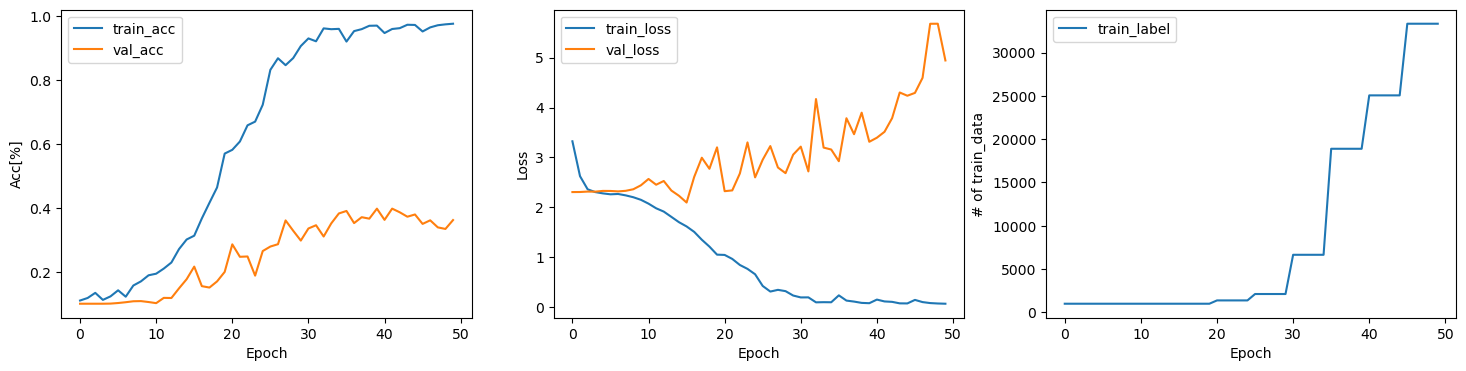

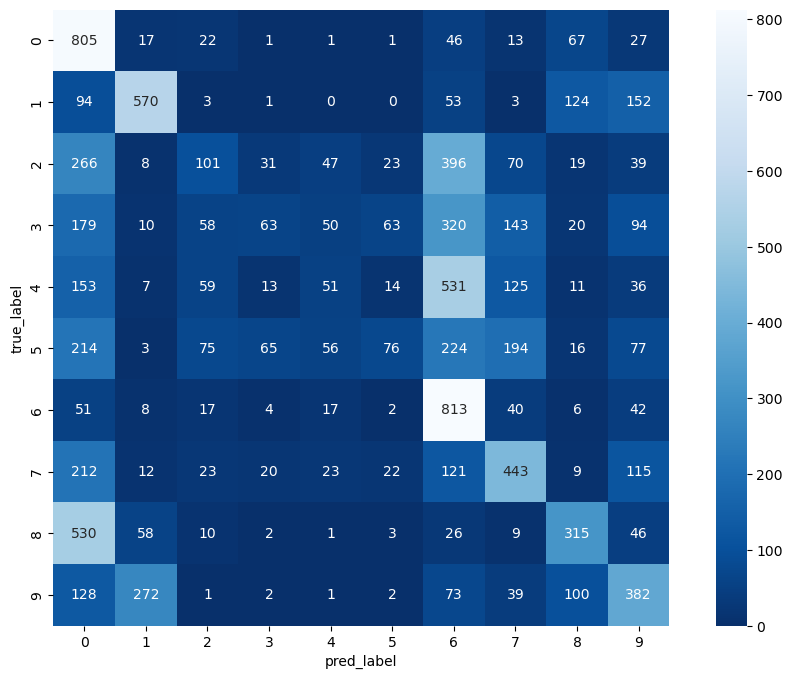

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels_true, labels_pred = model.val_tp(val_loader)

fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
fig.set_figwidth(6 * 3)
fig.set_figheight(4 * 1)

ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Acc[%]")
ax[0][0].plot(log_epoch, log_train_acc, label="train_acc")
ax[0][0].plot(log_epoch, log_val_acc, label="val_acc")
ax[0][0].legend()
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Loss")
ax[0][1].plot(log_epoch, log_train_loss, label="train_loss")
ax[0][1].plot(log_epoch, log_val_loss, label="val_loss")
ax[0][1].legend()
ax[0][2].set_xlabel("Epoch")
ax[0][2].set_ylabel("# of train_data")
ax[0][2].plot(log_epoch, log_num_labels, label="train_label")
ax[0][2].legend()

cm = confusion_matrix(labels_true, labels_pred)

fig, ax = plt.subplots()
fig.set_figwidth(12 * 1)
fig.set_figheight(8 * 1)
ax = sns.heatmap(cm, annot=True, cbar=True, square=True, fmt="d", cmap="Blues_r", xticklabels=list(range(cm.shape[0])), yticklabels=list(range(cm.shape[1])))
ax.set_xlabel("pred_label")
ax.set_ylabel("true_label")

